# Regression ABC using MDNs
MDN implementation based on this tutorial: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import torch
from torch.autograd import Variable
import torch.nn as nn

Let's first consider the simple example of an equally weighted mixture of Gaussians with equal mean. One of them with a std of 1, the other 0.1.

In [22]:
def simulator(mu):
    if np.random.rand() < 0.5:
        return np.random.normal(mu,1)
    else:
        return np.random.normal(mu,0.1)
    
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

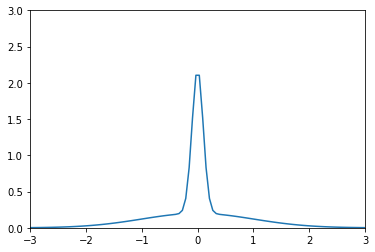

In [23]:
xx = np.linspace(-3,3,100)
plt.figure()
plt.plot(xx, posterior(xx))
plt.xlim((-3,3))
plt.ylim((0,3))
plt.show()

In [3]:
x_obs = 0.0

We use a uniform prior and generate 2500 samples, from which we generate the training set for our MDN.

In [4]:
NSAMPLE = 2500

theta = np.random.uniform(-2, 4, NSAMPLE)
theta.shape

(2500,)

In [5]:
x_data = np.array([simulator(theta_i) for theta_i in theta])
#x_data = summarize(x)
x_data.shape

(2500,)

Here, we adjust the number of hidden units and mixture components in the MDN

In [6]:
NHIDDEN = 50 # hidden units
KMIX = 2 # number of mixtures

In [7]:
class MDN(nn.Module):
    def __init__(self, hidden_size, num_mixtures, input_dim):
        super(MDN, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_size) 
        self.tanh = nn.Tanh()
        self.pi_out = torch.nn.Sequential(
              nn.Linear(hidden_size, num_mixtures),
              nn.Softmax()
            )
        self.sigma_out = nn.Linear(hidden_size, num_mixtures)
        self.mu_out = nn.Linear(hidden_size, num_mixtures)  

    def forward(self, x):
        out = self.fc_in(x)
        out = self.tanh(out)
        out_pi = self.pi_out(out)
        out_sigma = torch.exp(self.sigma_out(out))
        out_mu = self.mu_out(out)
        return (out_pi, out_sigma, out_mu)

Convert the training examples to torch tensors.

In [8]:
x_train = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, 1)).float())
theta_train = Variable(torch.from_numpy(theta.reshape(NSAMPLE, 1)).float(), requires_grad=False)

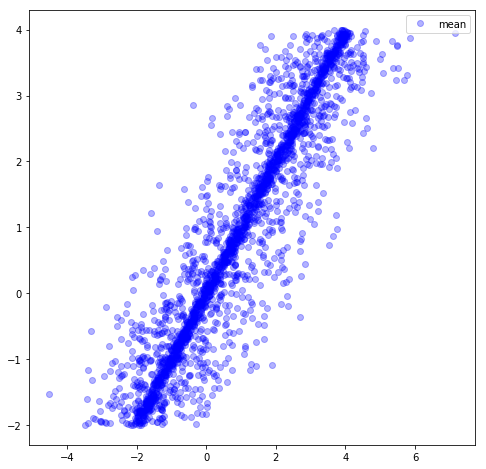

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(x_train.data.numpy()[:,0],theta_train.data.numpy(),'bo', alpha=0.3, label='mean')
#plt.plot(x_train.data.numpy()[:,1],theta_train.data.numpy(),'ro', alpha=0.3, label='std')
plt.legend()
plt.show()

We now define the loss function, which is simply the negative log likelihood of the training data under our model.

In [10]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
def gaussian_distribution(theta, mu, sigma):
    # braodcast subtraction with mean and normalization to sigma
    result = (theta.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = - 0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

In [11]:
def mdn_loss_function(out_pi, out_sigma, out_mu, theta):
    result = gaussian_distribution(theta, out_mu, out_sigma) * out_pi
    result = torch.sum(result, dim=1)
    result = - torch.log(result)
    return torch.mean(result)

In [12]:
model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=1)

In [13]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/home/dominik/anaconda3/envs/abc/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 4.28400182723999
500 0.7138336300849915
1000 0.5735103487968445
1500 0.5586788058280945
2000 0.5525190830230713
2500 0.5486164093017578
3000 0.5443081855773926
3500 0.5405954122543335
4000 0.537566602230072
4500 0.5352654457092285
5000 0.533415675163269
5500 0.5318228006362915
6000 0.530414342880249
6500 0.5291790962219238
7000 0.5280423164367676
7500 0.5270029902458191
8000 0.5260637402534485
8500 0.5253289937973022
9000 0.524482786655426
9500 0.5237311124801636


In [14]:
x_test = Variable(torch.from_numpy(np.array(x_obs).reshape(1, 1)).float())

In [15]:
(out_pi_test, out_sigma_test, out_mu_test) = model(x_test)

out_pi = out_pi_test.data.numpy().T
out_sigma = out_sigma_test.data.numpy().T
out_mu = out_mu_test.data.numpy().T

/home/dominik/anaconda3/envs/abc/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [16]:
xx = np.linspace(-3,3,100)

In [17]:
pdf = np.array([ss.norm.pdf(xx, mu, sigma) * pi for mu, sigma, pi in zip(out_mu, out_sigma, out_pi)])
pdf = pdf.sum(axis=0)

In [18]:
pdf.shape

(100,)

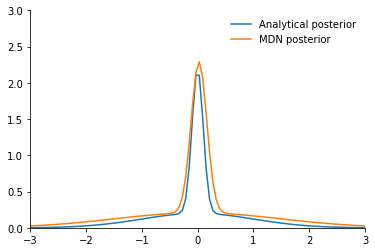

In [32]:
xx = np.linspace(-3,3,100)
f, ax = plt.subplots()
ax.plot(xx, posterior(xx), label='Analytical posterior')
ax.plot(xx, pdf, label='MDN posterior')
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()